In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from models import Dim
from datasets import fifa
import matplotlib.pyplot as plt
from math import floor
import numpy as np

In [2]:
# Instantiate dim. red. framework
dim = Dim()

# Load dataset
fifa = fifa()

X_train, X_test, y_train, y_test = train_test_split(fifa.X, fifa.y, test_size=0.1, random_state=33)
dim.col_names = fifa.col_names
dim.X_train = X_train
dim.y_train = y_train
dim.X_test = X_test
dim.y_test = y_test

dim.new_dim = dict()

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (25,108) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
# Unplickle dim
dim.unpickle_dim('dim/02-11-12:42.pkl')

# Read scores
scores = pd.read_csv('scores/07-04-20:42.csv')

# Filter for the best configuration
best_sc = scores.loc[scores.sort_values('Dimensions').groupby('Dim. Technique')['Accuracy'].idxmax()]

# Transform rows to dictionary keys
best_sc = [tuple(row) for row in best_sc[['Dimensions', 'Dim. Technique', 'Dim. Params']].to_records(index=False)]

# List execution parameters to plot
best_sc = [('3Dim', 'KPCA', 'Linear'),
 ('5Dim', 'LLE', 'k=81-reg=0.001'),
 ('5Dim', 'LOL', ''),
 ('4Dim', 'LPP', 'k=5'),
 ('3Dim', 'PCA', ''),
 ('2Dim', 'SLMVP', 'Radial-Gammas=0.1')]

# Select only the executions with the parameters of 'best_sc'
newdict = {k: dim.new_dim[k] for k in best_sc}
dim.new_dim = newdict

# Get the variability 
weights = dim.get_weights().droplevel(3, axis=1)

# Format weights
weigts_c = []
for key in dim.new_dim.keys():
    if weigts_c != '':
        weigts_c = weigts_c + weights[key].tolist()
weigts_c = [x for x in weigts_c if x != '']

# Get the  correlations
corrs = dim.get_corr_table(num_dim=None, abs=False)

# Multiply each column by corresponding weigth
for i, col in enumerate(corrs.columns):
    corrs[col] *= weigts_c[i]

# Initialize dictionary to hold lists of tuples
result_dict = {}

# Group tuples by their second element
for tup in corrs.keys():

    if tup[1] not in result_dict:
        result_dict[tup[1]] = [(tup)]
    else:
        result_dict[tup[1]].append((tup))

# Convert dictionary values to lists
header_groups = [values for values in result_dict.values()]

corrs_avg = pd.DataFrame()
for header_g in header_groups:
    corrs_avg[header_g[0][1]] = corrs[header_g].abs().mean(axis=1)

corrs_avg.head()

100%|██████████| 6/6 [00:00<00:00, 49.27it/s]


,KPCA,LLE,LOL,LPP,PCA,SLMVP
attacking_crossing,0.154895,0.064604,0.056178,0.103696,0.154895,0.128830
attacking_finishing,0.194530,0.056188,0.179025,0.098463,0.194530,0.300805
attacking_heading_accuracy,0.088898,0.055419,0.024725,0.101899,0.088898,0.205762
attacking_short_passing,0.128535,0.045738,0.024114,0.073680,0.128535,0.149742
attacking_volleys,0.193595,0.059671,0.162635,0.098280,0.193595,0.264689


/usr/local/lib/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


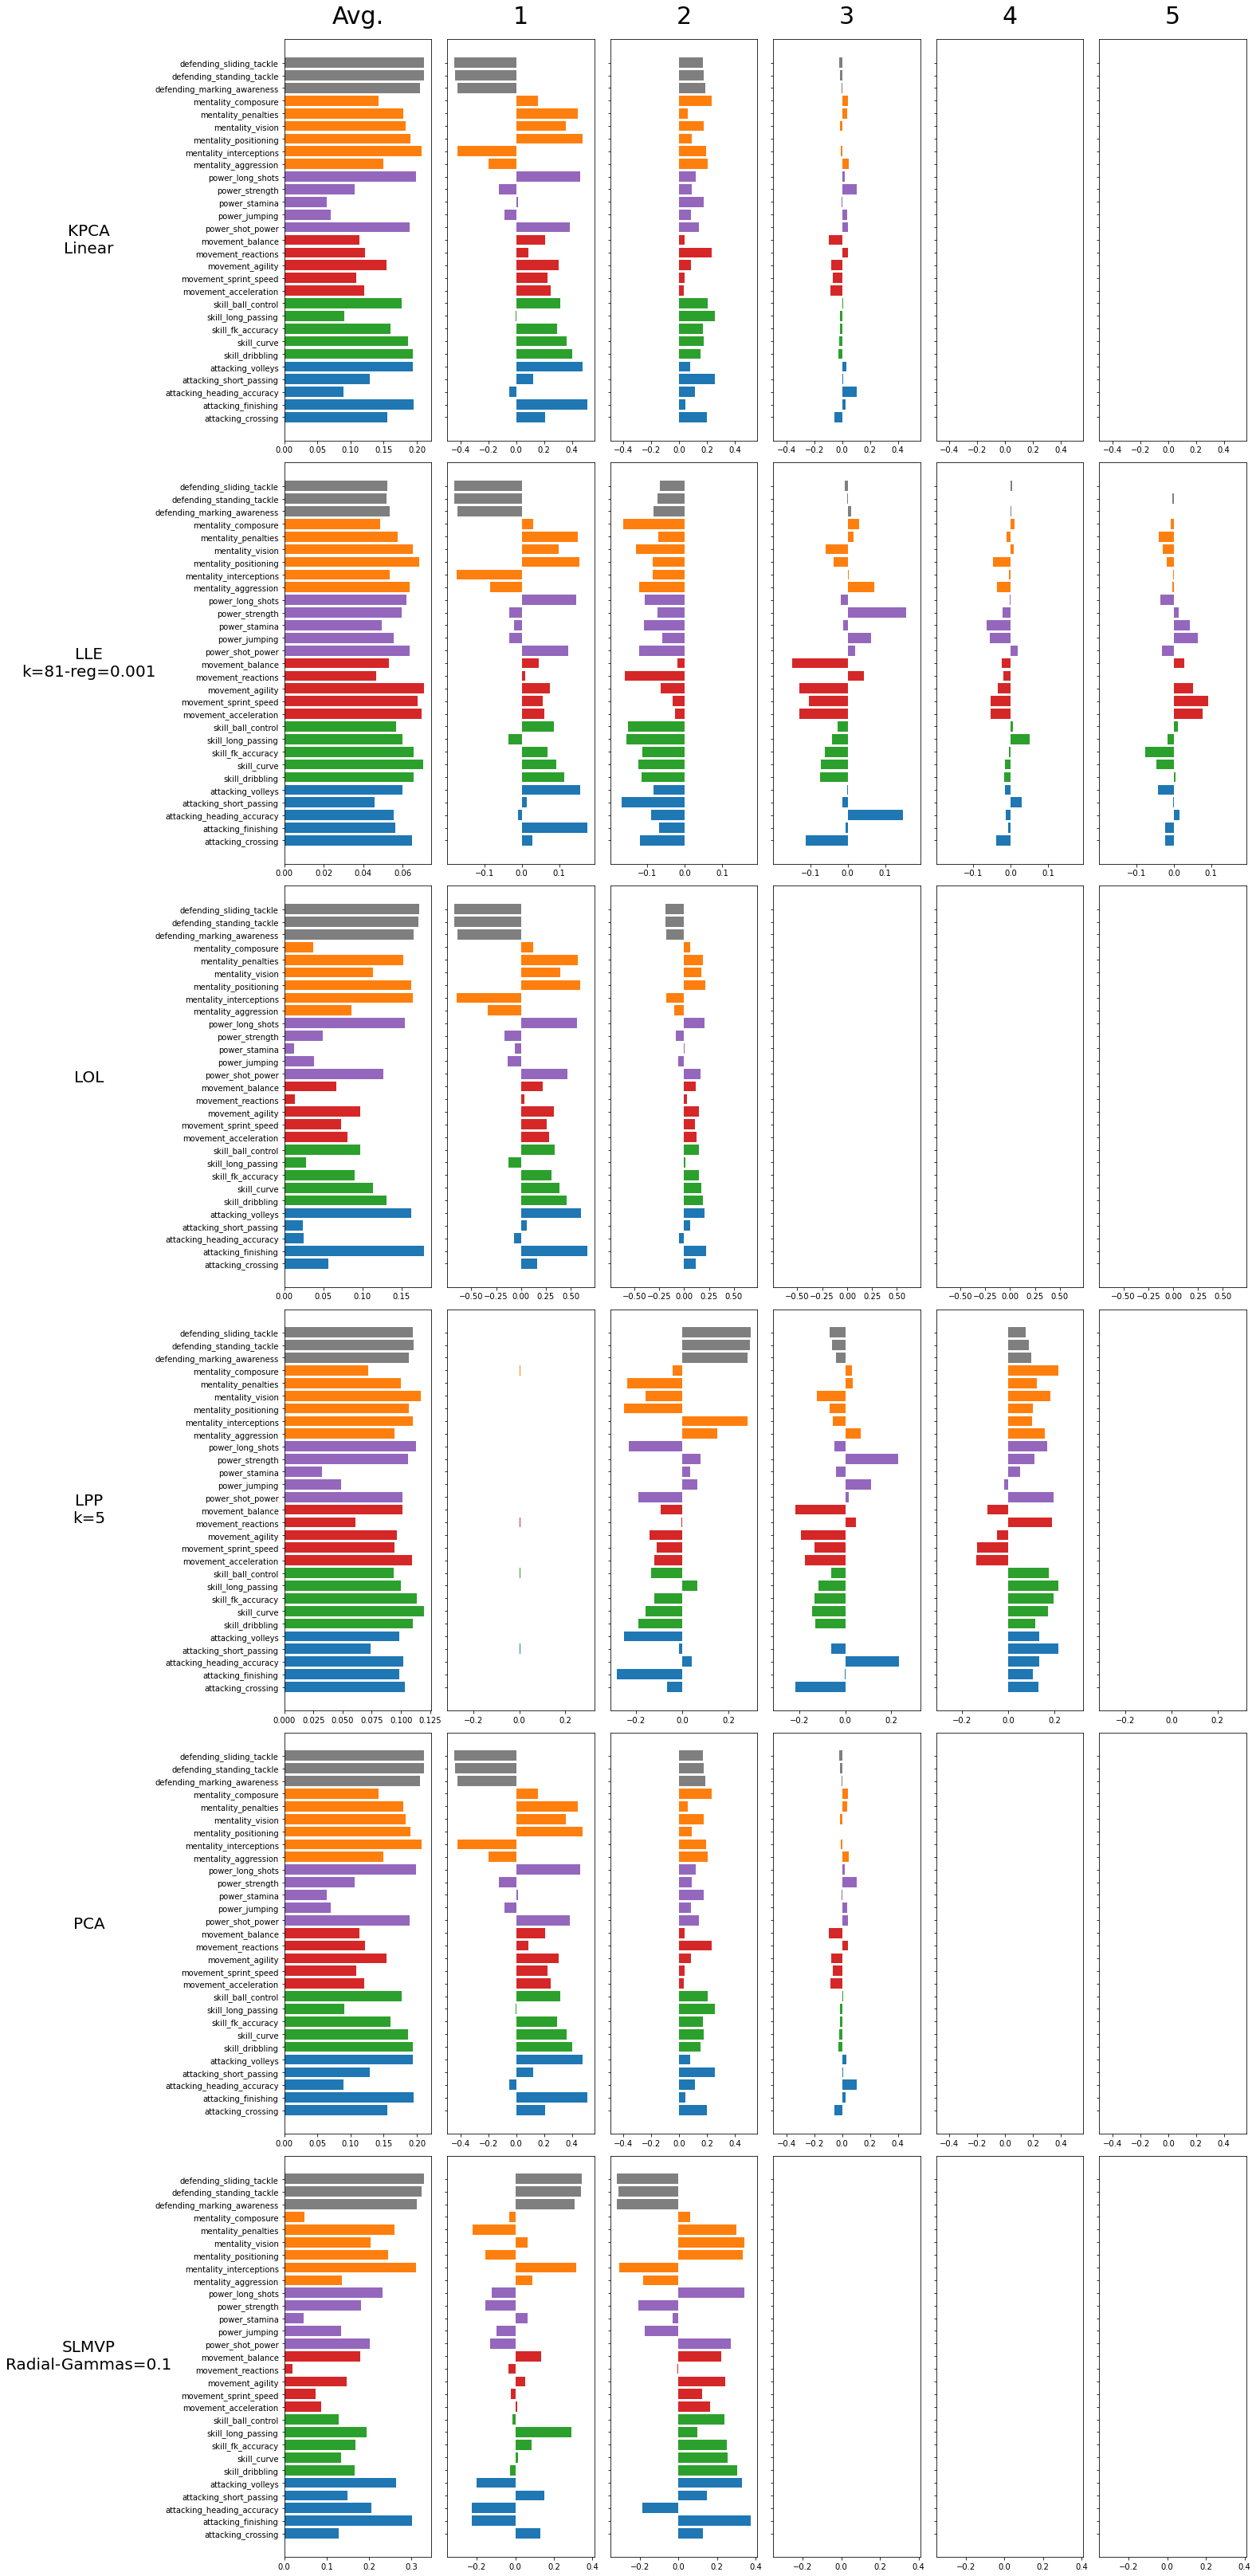

In [36]:
corrs['skill_set'] = corrs.index.to_series().str.split("_").str[0]
colors = corrs['skill_set'].map(
    {'attacking': '#1f77b4',
     'skill': '#2ca02c',
     'movement' : '#d62728',
     'power' : '#9467bd',
     'mentality' : '#ff7f0e',
     'defending' : '#7f7f7f'})

corrs.drop(columns=['skill_set'], inplace=True)

n_rows = 6
n_cols = 6

fig, ax = plt.subplots(
    n_rows, n_cols, figsize=(22, 45), sharey='row')

# Plot
pos = -1
for idx, key_dim in enumerate(list(corrs.keys())):
    values = corrs[key_dim]#.sort_values(ascending=True)
    categories = values.index
    if key_dim[-1] == 0:
        pos += 1
    ax[pos][key_dim[-1]+1].barh(categories, values, color=colors)
    #ax[floor(idx/n_cols)][idx % n_cols].set_title(key_dim)

# Plot avgs
for idx, key_dim in enumerate(list(corrs_avg.keys())):
    values = corrs_avg[key_dim]#.sort_values(ascending=True)
    categories = values.index
    ax[idx][0].barh(categories, values, color=colors)
    
# Add column labels
col_labels = ['Avg.', '1', '2', '3', '4', '5']
for ax_, col in zip(ax[0], col_labels):
    ax_.annotate(col, xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size=30, ha='center', va='baseline')

# Add row lables
row_labels = [x[1] + '\n' + x[2] for x in corrs.keys().to_list()]
row_labels = [x for i, x in enumerate(row_labels) if x not in row_labels[:i]]
for ax_, row in zip(ax[:,0], row_labels):
    ax_.annotate(row, xy=(0, 0.5), xytext=(-ax_.yaxis.labelpad - 75, 0),
                xycoords=ax_.yaxis.label, textcoords='offset points',
                size=20, ha='center', va='center')
    
plt.subplots_adjust(hspace=0.0)  # Adjusting spacing between subplots

# Set the range of the x-axis for all plots
for ax_row in ax:
    # Get x-axis range for the correlations of the dim with the highest
    xlims = [x.get_xlim() for x in ax_row[1:]]
    # Remove x lims for the empty plots, tuples (0.0, 1.0)
    xlims = [x for x in xlims if x != (0.0, 1.0)]
    # Select the biggest xlim
    xlim = max(xlims, key=lambda t: abs(t[0] - t[1]))
    for ax_ in ax_row[1:]:
        ax_.set_xlim(xlim)

plt.tight_layout()
plt.show()


## Feature Selection #10

In [34]:
xlims = [(-0.494762486893966, 0.5612782533563823), (0.0, 0.26644455392785277), (-0.10332794494847916, 0.11232794139960206), (0.0, 1.0), (0.0, 1.0)]
xlims = [x for x in xlims if x != (0.0, 1.0)]
xlims

[(-0.494762486893966, 0.5612782533563823),
 (0.0, 0.26644455392785277),
 (-0.10332794494847916, 0.11232794139960206)]

In [35]:
max(xlims, key=lambda t: abs(t[0] - t[1]))

(-0.494762486893966, 0.5612782533563823)